## INITIAL PREPARATION
Imports, root dir

#### Data investigation is not included here

In [1]:
DATA_DIR='playground-series-s3e3/'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import datetime
import pickle

from training_lib import *

In [3]:
df=pd.read_csv(DATA_DIR+"/train.csv").iloc[:,1:] #drop ID

## DATASET PREPARATION
column drops, union, one-hoe encoding, normalization

In [5]:
#toBins [('column1',bins1),('column2',bins2)] - turn each specified number fearure into <bin> separate values
#unite [['column1','column2','column3'],['column1','column5']] - unite columns, replace with mean target (y) order
#     should be good if rows are too few and feats are too many
#drop ['column1',2,3] - drop columns
#one-hot True - run get_dummies to turn any str feature into one-hot encoding
#norm - normalization, "minmax" - turn to 0..1

def col(df,column): #get column name for non-str column
    if type(column)!=str:
        return df.columns[column]
    return column

def prepareDataset(df, targetCol, datasetParams, dfTest=None, verb=0):
    #Prepare dataset, using customization parameters
    #also prepare test data (without y) if provided
    df_updated = df.copy() #copy original df not to spoil it
    test = not (dfTest is None)
    if test:
        dfTest_updated=dfTest.copy()
    params = datasetParams.copy()
    defaultParams = {"TO_BINS":[],"UNITE":[],"DROP":[],"ONE-HOT":False,"NORM":"None"}
    for p in defaultParams: #use default params for missing
        if not (p in params): params[p] = defaultParams[p]
    targetCol = col(df, targetCol)
    df_updated = df_updated.drop(targetCol, axis = 1) #drop target column, to add in the end
    if test and (targetCol in dfTest_updated.columns):
        dfTest_updated = dfTest_updated.drop(targetCol, axis = 1)
    #############################################
    for pair in params["TO_BINS"]: #slice these num feats by bins
        c = col(df_updated,pair[0])
        minVal, maxVal = df_updated[c].min(), df_updated[c].max()
        binSize = (maxVal-minVal) / pair[1]
        df_updated[c] = df_updated[c] - minVal
        df_updated[c] = df_updated[c].floordiv(binSize) * binSize
        if test:
            dfTest_updated[c] = dfTest_updated[c] - minVal
            dfTest_updated[c] = dfTest_updated[c].floordiv(binSize) * binSize
        if verb >= 2: #make histogram to check how consistent are values
            plt.figure()
            df_updated[c].hist()
    #############################################          
    for union in params["UNITE"]: #unite features
        cols = [] #get columns in one format
        newColumnName = "" #new column name from these columns
        for column in union:
            cols.append(df_updated.columns.get_loc(col(df_updated,column)))
            newColumnName += df_updated.columns[cols[-1]] + "_"
        newColumnName = newColumnName[:-1]
        newColumnInd = len(df_updated.columns)
        df_updated[newColumnName] = df_updated.iloc[:,0] #just add new column
        if test:
            dfTest_updated[newColumnName] = dfTest_updated.iloc[:,0] #just add new column

        uValues = {} #new unique values and mean target for them
        for row in range(df_updated.shape[0]):
            unionValue = ""
            for c in cols: #get new value from union
                unionValue += str(df_updated.iat[row,c])+"_"
            uValues[unionValue] = 0
            df_updated.iat[row,newColumnInd] = unionValue #put the new value to the new column
            
        if test: #same for submission or validation
            for row in range(dfTest_updated.shape[0]):
                unionValue=""
                for c in cols: #get new value from union
                    unionValue += str(dfTest_updated.iat[row,c])+"_"
                uValues[unionValue] = 0
                dfTest_updated.iat[row,newColumnInd] = unionValue #put the new value to the new column
                
        valList=[] #put mean targets in list to sort and get order (useless for decision trees)
        for val in uValues:
            newVal = df[df_updated[newColumnName] == val][targetCol].mean()
            uValues[val] = newVal
            valList.append((newVal,val))
        valList=sorted(valList)
        for p in valList:
            df_updated[newColumnName] = df_updated[newColumnName].replace(p[1],p[0])
            if test:
                dfTest_updated[newColumnName] = dfTest_updated[newColumnName].replace(p[1],p[0])
                
        if verb >= 2: #make histogram to check how consistent are values
            plt.figure()
            df_updated[newColumnName].hist()

        if verb>=1: #print count of new values, this shouldn't be too big for dataset
            print(newColumnName,len(uValues))
    #############################################        
    #perform columns drop
    df_updated = df_updated.drop(df_updated.columns[params["DROP"]], axis = 1)
    if test:
        dfTest_updated = dfTest_updated.drop(dfTest_updated.columns[params["DROP"]], axis = 1)
    #############################################    
    if params["ONE-HOT"]==True:
        df_updated = pd.get_dummies(df_updated)
        if test:
            dfTest_updated = pd.get_dummies(dfTest_updated)
    #############################################        
    if params["NORM"]=="minmax":
        df_updated=(df_updated-df_updated.min())/(df_updated.max()-df_updated.min())
        if test:
            dfTest_updated=(dfTest_updated - df_updated.min()) / (df_updated.max() - df_updated.min())
        #sc = StandardScaler() #can be used later for something else
        #X[num_cols] = sc.fit_transform(X[num_cols])
    #############################################
    if not test:
        if verb >= 1:
            print(df_updated.columns)
        return (df_updated.values, df[targetCol].values)
    if test:
        if verb >= 1:
            print('train',df_updated.columns)
            print('val/sub',dfTest_updated.columns)
        return (df_updated.values, df[targetCol].values, dfTest_updated.values)
    
NEED_TEST = True #run test in case of RnD or param search
if NEED_TEST:
    datasetParams={}
    X, Y = prepareDataset(df, df.columns[-1], datasetParams, verb=2)

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


## TRAINING FUNCTIONS
grid run, tensorflow, catboost, xgboost. Should be in training_lib, but RnD can be done here

### Grid run (upper as should be changed less frequently than training (or not))

In [6]:
#dirty

#getParamConfigList should be in training_lib
def runGridTest(df, datasetParams={}, trainingParams={}, libSpecificParams={}, kfolds=10, stopRightAway=False):
    datasetParamsList = getParamConfigList(datasetParams)
    trainingParamsList = getParamConfigList(trainingParams)
    libSpecificParamsList = getParamConfigList(libSpecificParams)
    print(len(datasetParamsList),'dataset params configs')
    print(len(trainingParamsList),'training params configs')
    print(len(libSpecificParamsList),'lib specific params configs')
    print(len(datasetParamsList)*len(trainingParamsList)*len(libSpecificParamsList),'all params configs')
    print('datasetParams',datasetParamsList)
    print('trainingParams',trainingParamsList)
    print('libSpecificParams',libSpecificParamsList)
    results=[]
    for datasetParamConfig in datasetParamsList:
        #(df, targetCol, datasetParams, dfTest=None, verb=0)
        X, Y = prepareDataset(df, df.columns[-1], datasetParamConfig) #prepare dataset with this param configurations
        for trainingParamConfig in trainingParamsList:
            for libSpecificParamConfig in libSpecificParamsList:
                totalRes=0
                AUCs=[]
                stf = StratifiedKFold(kfolds, shuffle=True, random_state=1) #make k-folds
                for train_ix, test_ix in tqdm(stf.split(X, Y), total = kfolds):
                    if True:
                        df2=df.iloc[train_ix]
                        subDf=df.iloc[test_ix]
                        X_Train, Y_Train, X_Test = prepareDataset(df2, df.columns[-1], datasetParamConfig, subDf)
                        
                        Y_Pred=trainingParamConfig["FUNC"](X_Train, Y_Train, X_Test, subDf.iloc[:,-1].values, X_Test, trainingParamConfig, libSpecificParamConfig) #run training and get predictions
                    else:
                        Y_Pred=trainingParamConfig["FUNC"](X[train_ix], Y[train_ix], X[test_ix], Y[test_ix], X[test_ix], trainingParamConfig, libSpecificParamConfig) #run training and get predictions
                    #auc=roc_auc_score(Y[test_ix], Y_Pred) #calculate AUC
                    #print(auc,'pre-auc')
                    #Y_Pred=fixPredsForAUC(Y_Pred)
                    auc=roc_auc_score(Y[test_ix], Y_Pred) #calculate AUC
                    #print(auc,'auc')
                    totalRes+=auc
                    AUCs.append(auc)
                    predsFalse=[]
                    predsTrue=[]
                    for i in range(len(Y[test_ix])):
                        if Y[test_ix][i]==0:
                            predsFalse.append(Y_Pred[i])
                        else:
                            predsTrue.append(Y_Pred[i])
                    #plt.figure(figsize=(8,8))
                    #plt.hist(predsFalse,color='blue',bins=30)
                    #plt.hist(predsTrue*10,color='red',bins=30)
                    if stopRightAway:
                        break
                #plt.figure()
                #plt.hist(AUCs) #hist for AUCs in k-folds
                #plt.title(str(totalRes/kfolds)+" "+str(datasetParamConfig)+" "+str(trainingParamConfig))
                print("kfolded auc",totalRes/kfolds,str(datasetParamConfig)+" "+str(trainingParamConfig)+" "+str(libSpecificParamConfig))
                results.append((totalRes/kfolds,str(datasetParamConfig)+" "+str(trainingParamConfig)+" "+str(libSpecificParamConfig)))
    return results

## Ensemble

In [ ]:
#nothing yet


### CatBoost, sklearn RandomForest. And other to do (xgboost, something else)...

In [7]:
#dirty

#catboost training functions
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

def catBoostTrain(X,Y,X_val,Y_val,X_test,trainingParams,libSpecificParams):
    params=trainingParams.copy()
    defaultParams={"ITERS":300,"LOSS":"Poisson","SEED":1} #"st_weight":1,
    for p in defaultParams:
        if not (p in params):
            params[p] = defaultParams[p]
    cat = CatBoostRegressor(iterations=params["ITERS"], loss_function=params["LOSS"], use_best_model=True, thread_count=2, random_seed=params["SEED"],**libSpecificParams) #, hints="skip_train~false")#, use_best_model=True) #class_weights={0:1,1:params["st_weight"]}, 
    cat_feats=[] #handle str and other features
    sample_weight=np.ones(len(Y))
    if ("CLASS_WEIGHT" in trainingParams) and (trainingParams["CLASS_WEIGHT"]>1):
        w=trainingParams["CLASS_WEIGHT"]
        for i in range(len(Y)):
            if Y[i]==1:
                sample_weight[i]=w
    for i in range(X.shape[1]):
        if type(X[0,i])==str:
            cat_feats.append(i)
    cat.fit(X, Y, cat_features=cat_feats, plot=False, verbose=False, eval_set=(X_val,Y_val), sample_weight=sample_weight) #train
    #return cat.predict_proba(X_test)[:,1] #return probabilities of 1
    return cat.predict(X_test)

#random forest training

from sklearn.ensemble import RandomForestClassifier

def randomForestTrain(X,Y,X_val,Y_val,X_test,trainingParams,libSpecificParams):
    rfc = RandomForestClassifier(random_state=1,**libSpecificParams) #n_estimators=3,max_depth=2,
    rfc.fit(X, Y.reshape(-1))
    return rfc.predict_proba(X_test)[:,1]

#xgboost

import xgboost as xgb

def XGBTrain(X,Y,X_val,Y_val,X_test,trainingParams,libSpecificParams): #trainX,indTrainX,trainY,valX,indValX,params):
    model=xgb.XGBRegressor(**libSpecificParams)
    model.fit(X,Y)
    preds=model.predict(X_test)
    return preds
    
#Testing development
NEED_TEST = False
if NEED_TEST:
    datasetParams={"ONE-HOT":True}
    X, Y = prepareDataset(df, datasetParams) #prepare dataset with all the params
    rfc = RandomForestClassifier(random_state=1)
    rfc.fit(X[:-1000], Y[:-1000].reshape(-1))
    Y_Pred=rfc.predict_proba(X[-1000:])[:,1]
    auc=roc_auc_score(Y[-1000:], Y_Pred) #cal

### TensorFlow

In [36]:
#dirty and stupid lib version

#tensorflow training
from tensorflow.python.keras import layers as L
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import regularizers
import numpy as np

import tensorflow as tf
print('tensorflow version',tf.__version__)

def buildDense(columns,params):
    #Build dense neural network model
    inputLayer=L.Input(columns,name="Input")
    X=inputLayer
    for layer in params["LAYERS"]:
        X=L.Dense(layer,activation=None,activity_regularizer=params["REGULARIZATION"])(X)
        #X=L.BatchNormalization()(X)
        if params["DROPOUT"]>0:
            X=L.Dropout(params["DROPOUT"])(X)
        X=L.Activation(activation=params["ACTIVATION"])(X)
    output=L.Dense(1,activation="tanh")(X)
    model = Model(inputs=[inputLayer], outputs=[output])
    return model

def tensorFlowTrain(X,Y,X_val,Y_val,X_test,trainingParams,libSpecificParams):
    params=trainingParams.copy()
    defaultParams={"MODEL":buildDense,"LAYERS":[64],"ACTIVATION":"relu","DROPOUT":0,"REGULARIZATION":None,"LOSS":"mse","ITERS":50,"OPTIMIZER":"Adam","LR":0.001,"VERB":0}
    for p in defaultParams:
        if not (p in params):
            params[p] = defaultParams[p]
    model=params["MODEL"](X.shape[1],params)
    model.compile(loss=params["LOSS"], optimizer=params["OPTIMIZER"])
    K.set_value(model.optimizer.learning_rate, params["LR"])
    hist=model.fit(X,Y,epochs=params["ITERS"],validation_split=0.05,verbose=params["VERB"])
    preds=model.predict(X_test)
    return preds

NEED_TEST = False
if NEED_TEST:
    pass #code to run this

2023-01-17 19:47:42.684566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 19:47:42.684599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tensorflow version 2.8.0


Using TensorFlow backend.


## RUNNING CONFIGS

#### Can be done in separate files for clarity

In [37]:
datasetParams={}
trainingParams={"FUNC":catBoostTrain}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)

<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>}]
libSpecificParams [{}]


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]

kfolded auc 0.8410590182018753 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>} {}


In [38]:
datasetParams={"ONE-HOT":True}
trainingParams={"FUNC":[randomForestTrain,XGBTrain]}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)

True <class 'bool'>
[<function randomForestTrain at 0x7fca9b7f28b0>, <function XGBTrain at 0x7fca9937d700>] <class 'list'>
1 dataset params configs
2 training params configs
1 lib specific params configs
2 all params configs
datasetParams [{'ONE-HOT': True}]
trainingParams [{'FUNC': <function randomForestTrain at 0x7fca9b7f28b0>}, {'FUNC': <function XGBTrain at 0x7fca9937d700>}]
libSpecificParams [{}]


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.15it/s]


kfolded auc 0.8128746093031808 {'ONE-HOT': True} {'FUNC': <function randomForestTrain at 0x7fca9b7f28b0>} {}


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.07s/it]

kfolded auc 0.742064487957345 {'ONE-HOT': True} {'FUNC': <function XGBTrain at 0x7fca9937d700>} {}


In [85]:
datasetParams={}
trainingParams={"FUNC":catBoostTrain,"LOSS":["LogLinQuantile","RMSE","Poisson"],"ITERS":[50,500,2000,5000]}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)

<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
['LogLinQuantile', 'RMSE', 'Poisson'] <class 'list'>
[50, 500, 2000, 5000] <class 'list'>
[50, 500, 2000, 5000] <class 'list'>
[50, 500, 2000, 5000] <class 'list'>
1 dataset params configs
12 training params configs
1 lib specific params configs
12 all params configs
datasetParams [{}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 50}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 2000}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 5000}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 50}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 2000}, {'FUNC

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]


kfolded auc 0.8105685787828645 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 50} {}


100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


kfolded auc 0.828937074829932 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500} {}


100%|███████████████████████████████████████████| 10/10 [02:10<00:00, 13.08s/it]


kfolded auc 0.8169943923515351 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 2000} {}


100%|███████████████████████████████████████████| 10/10 [04:44<00:00, 28.44s/it]


kfolded auc 0.8150951461665749 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 5000} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


kfolded auc 0.832892305570877 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 50} {}


100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.38s/it]


kfolded auc 0.8447853465710609 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 500} {}


100%|███████████████████████████████████████████| 10/10 [01:38<00:00,  9.81s/it]


kfolded auc 0.8380848961206103 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 2000} {}


100%|███████████████████████████████████████████| 10/10 [05:03<00:00, 30.37s/it]


kfolded auc 0.8410077679720537 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 5000} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.81it/s]


kfolded auc 0.8251941993013421 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 50} {}


100%|███████████████████████████████████████████| 10/10 [00:54<00:00,  5.46s/it]


kfolded auc 0.8418360452289024 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500} {}


100%|███████████████████████████████████████████| 10/10 [02:10<00:00, 13.10s/it]


kfolded auc 0.8421400992829564 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {}


100%|███████████████████████████████████████████| 10/10 [05:33<00:00, 33.37s/it]

kfolded auc 0.8421400992829564 {} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 5000} {}


In [49]:
for i,c in enumerate(df.columns):
    print(i,c,len(df[c].unique()))

0 Age 43
1 BusinessTravel 3
2 DailyRate 625
3 Department 3
4 DistanceFromHome 29
5 Education 6
6 EducationField 6
7 EmployeeCount 1
8 EnvironmentSatisfaction 4
9 Gender 2
10 HourlyRate 71
11 JobInvolvement 4
12 JobLevel 6
13 JobRole 9
14 JobSatisfaction 4
15 MaritalStatus 3
16 MonthlyIncome 895
17 MonthlyRate 903
18 NumCompaniesWorked 10
19 Over18 1
20 OverTime 2
21 PercentSalaryHike 15
22 PerformanceRating 2
23 RelationshipSatisfaction 4
24 StandardHours 1
25 StockOptionLevel 4
26 TotalWorkingYears 41
27 TrainingTimesLastYear 7
28 WorkLifeBalance 4
29 YearsAtCompany 34
30 YearsInCurrentRole 19
31 YearsSinceLastPromotion 16
32 YearsWithCurrManager 18
33 Attrition 2


In [43]:
print(df.columns)

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition'],
      dtype='object')


BusinessTravel_Department_EnvironmentSatisfaction 32
Education_EducationField 29
JobLevel_Gender_OverTime 21
JobInvolvement_WorkLifeBalance 16
JobRole_MaritalStatus 27
PerformanceRating_TrainingTimesLastYear 14
NumCompaniesWorked_JobSatisfaction 40
Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'PercentSalaryHike', 'RelationshipSatisfaction',
       'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Department_EnvironmentSatisfaction',
       'Education_EducationField', 'JobLevel_Gender_OverTime',
       'JobInvolvement_WorkLifeBalance', 'JobRole_MaritalStatus',
       'PerformanceRating_TrainingTimesLastYear',
       'NumCompaniesWorked_JobSatisfaction'],
      dtype='object')


/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


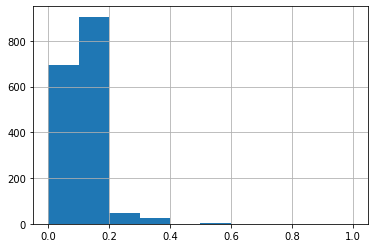

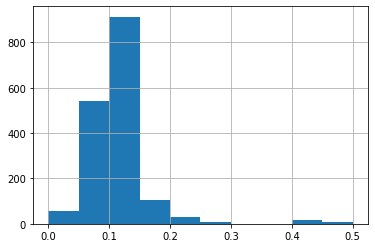

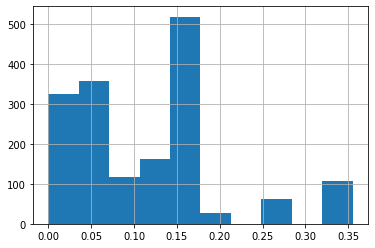

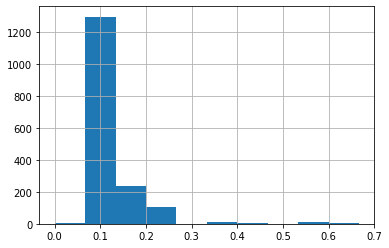

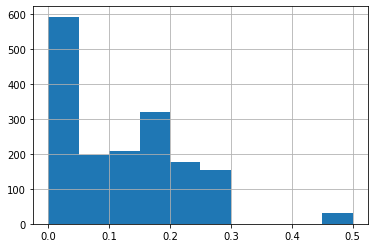

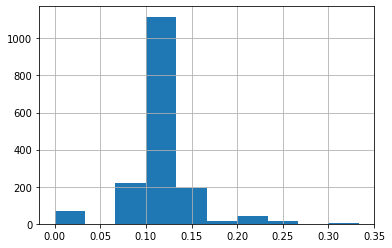

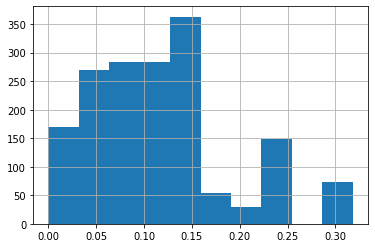

In [61]:
#find something to unite and remove
datasetParams={"DROP":[[1,3,5,6,8,9,11,12,13,14,15,18,20,22,25,27,28, 7,19,24]],"UNITE":[[1,3,8],[5,6],[12,9,20],[11,28],[13,15],[22,27],[18,14]]} #drop 1-variant columns, unite (and drop) few-variants columns
trainingParams={"FUNC":catBoostTrain,"LOSS":"Poisson","ITERS":2000}
libSpecificParams={}

X,Y = prepareDataset(df, df.columns[-1], datasetParams, verb=2)

In [86]:
datasetParams={"DROP":[[[1,3,5,6,8,9,11,12,13,14,15,18,20,22,25,27,28, 7,19,24]]],"UNITE":[[[1,3,8],[5,6],[12,9,20],[11,28],[13,15],[22,27],[18,14]]]} #drop 1-variant columns, unite (and drop) few-variants columns
trainingParams={"FUNC":catBoostTrain,"LOSS":["Poisson","LogLinQuantile"],"ITERS":[500,2000]}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)

[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
['Poisson', 'LogLinQuantile'] <class 'list'>
[500, 2000] <class 'list'>
[500, 2000] <class 'list'>
1 dataset params configs
4 training params configs
1 lib specific params configs
4 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITER

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:34,  3.85s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8093594870380585 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:07<01:04,  7.14s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:14<00:57,  7.18s/it]/usr/local/lib/python3

kfolded auc 0.8093594870380585 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:30,  3.41s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:06<00:28,  3.50s/it]/usr/local/lib/python3

kfolded auc 0.8009546791689649 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:32,  3.60s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:07<00:32,  4.05s/it]/usr/local/lib/python3

kfolded auc 0.7981129343629344 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 2000} {}


BusinessTravel_Gender 6
Department_EnvironmentSatisfaction 12
Education_EducationField 29
JobLevel_OverTime 11
JobInvolvement_WorkLifeBalance 16
JobRole_MaritalStatus 27
PerformanceRating_TrainingTimesLastYear 14
Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'JobSatisfaction',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'RelationshipSatisfaction', 'TotalWorkingYears',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'BusinessTravel_Gender',
       'Department_EnvironmentSatisfaction', 'Education_EducationField',
       'JobLevel_OverTime', 'JobInvolvement_WorkLifeBalance',
       'JobRole_MaritalStatus', 'PerformanceRating_TrainingTimesLastYear'],
      dtype='object')


/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


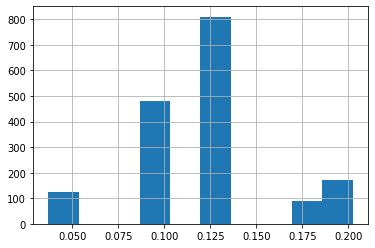

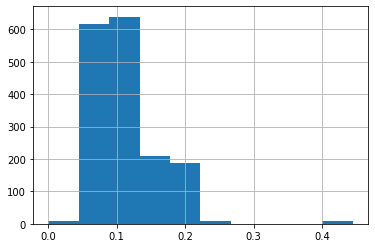

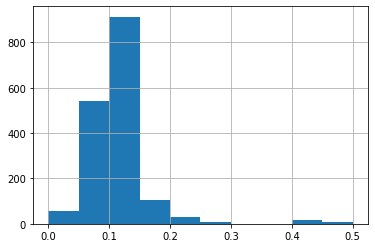

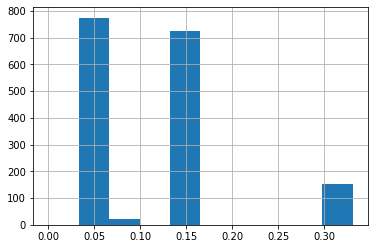

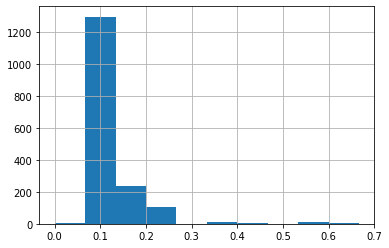

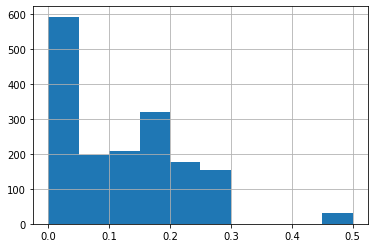

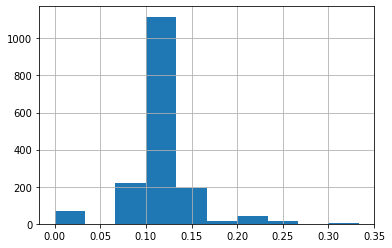

In [91]:
#find something to unite and remove (smaller)
datasetParams={"DROP":[[1,3,5,6,8,9,11,12,13,15,20,22,25,27,28, 7,19,24]],"UNITE":[[1,9],[3,8],[5,6],[12,20],[11,28],[13,15],[22,27]]} #drop 1-variant columns, unite (and drop) few-variants columns
#trainingParams={"FUNC":catBoostTrain,"LOSS":"Poisson","ITERS":2000}
libSpecificParams={}

X,Y = prepareDataset(df, df.columns[-1], datasetParams, verb=2)

In [93]:
datasetParams={"DROP":[[[1,3,5,6,8,9,11,12,13,15,20,22,25,27,28, 7,19,24]]],"UNITE":[[[1,9],[3,8],[5,6],[12,20],[11,28],[13,15],[22,27]]]} #drop 1-variant columns, unite (and drop) few-variants columns
trainingParams={"FUNC":catBoostTrain,"LOSS":["Poisson","LogLinQuantile","RMSE"],"ITERS":[500,1000]}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)

[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
['Poisson', 'LogLinQuantile', 'RMSE'] <class 'list'>
[500, 1000] <class 'list'>
[500, 1000] <class 'list'>
[500, 1000] <class 'list'>
1 dataset params configs
6 training params configs
1 lib specific params configs
6 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 1000}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'I

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:02<00:21,  2.40s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8244647453576025 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:28,  3.13s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:06<00:25,  3.18s/it]/usr/local/lib/python3

kfolded auc 0.8244647453576025 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 1000} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:02<00:21,  2.42s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:04<00:19,  2.39s/it]/usr/local/lib/python3

kfolded auc 0.7953975914690201 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:28,  3.17s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:06<00:23,  2.97s/it]/usr/local/lib/python3

kfolded auc 0.7935695899981614 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 1000} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:02<00:25,  2.81s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:05<00:22,  2.87s/it]/usr/local/lib/python3

kfolded auc 0.8161435925721641 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:33,  3.76s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:07<00:31,  3.98s/it]/usr/local/lib/python3

kfolded auc 0.8228065820922964 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 1000} {}


In [96]:
datasetParams={"DROP":[[[1,3,5,6,8,9,11,12,13,15,20,22,25,27,28, 7,19,24]]],"UNITE":[[[1,9],[3,8],[5,6],[12,20],[11,28],[13,15],[22,27]]],"TO_BINS":[[["Age",5],["DistanceFromHome",5],["TotalWorkingYears",4]]]} #drop 1-variant columns, unite (and drop) few-variants columns
trainingParams={"FUNC":catBoostTrain,"LOSS":["Poisson","LogLinQuantile","RMSE"],"ITERS":[500,1000]}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)

[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]]] <class 'list'>
[[['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
['Poisson', 'LogLinQuantile', 'RMSE'] <class 'list'>
[500, 1000] <class 'list'>
[500, 1000] <class 'list'>
[500, 1000] <class 'list'>
1 dataset params configs
6 training params configs
1 lib specific params configs
6 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500}, {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 1000}, {'FUNC': <function

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:02<00:24,  2.72s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8190177422320278 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:04<00:39,  4.37s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:08<00:34,  4.25s/it]/usr/local/lib/python3

kfolded auc 0.8190177422320278 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 1000} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:02<00:26,  2.94s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:06<00:25,  3.17s/it]/usr/local/lib/python3

kfolded auc 0.7943096157381871 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:04<00:42,  4.68s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:09<00:38,  4.79s/it]/usr/local/lib/python3

kfolded auc 0.7933650487221915 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'LogLinQuantile', 'ITERS': 1000} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:03<00:31,  3.55s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:07<00:28,  3.53s/it]/usr/local/lib/python3

kfolded auc 0.8152868174296746 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 500} {}


  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:04<00:44,  4.93s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 20%|████████▊                                   | 2/10 [00:10<00:40,  5.04s/it]/usr/local/lib/python3

kfolded auc 0.8187408071336643 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 15, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 9], [3, 8], [5, 6], [12, 20], [11, 28], [13, 15], [22, 27]], 'TO_BINS': [['Age', 5], ['DistanceFromHome', 5], ['TotalWorkingYears', 4]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'RMSE', 'ITERS': 1000} {}


In [14]:
#checking all possible column drops
import pickle

drops=[[]]
for a1 in range(len(df.columns)-1):
    drops.append([a1])
    for a2 in range(a1+1,len(df.columns)-1):
        drops.append([a1,a2])
        '''for a3 in range(a2+1,len(df.columns)-1):
            drops.append([a1,a2,a3])
            for a4 in range(a3+1,len(df.columns)-1):
                drops.append([a1,a2,a3,a4])
                for a5 in range(a4+1,len(df.columns)-1):
                    drops.append([a1,a2,a3,a4,a5])
                    for a6 in range(a5+1,len(df.columns)-1):
                        drops.append([a1,a2,a3,a4,a5,a6])
                        for a7 in range(a6+1,len(df.columns)-1):
                            drops.append([a1,a2,a3,a4,a5,a6,a7])
                            for a8 in range(a7+1,len(df.columns)-1):
                                drops.append([a1,a2,a3,a4,a5,a6,a7,a8])
                                for a9 in range(a8+1,len(df.columns)-1):
                                    drops.append([a1,a2,a3,a4,a5,a6,a7,a8,a9])''';
print(len(drops))
datasetParams={"DROP":drops}
trainingParams={"FUNC":catBoostTrain,"ITERS":10}
libSpecificParams={}

res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)
with open("res.pickle","wb") as f:
    pickle.dump(res,f)

562
[[], [0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11], [0, 12], [0, 13], [0, 14], [0, 15], [0, 16], [0, 17], [0, 18], [0, 19], [0, 20], [0, 21], [0, 22], [0, 23], [0, 24], [0, 25], [0, 26], [0, 27], [0, 28], [0, 29], [0, 30], [0, 31], [0, 32], [1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29], [1, 30], [1, 31], [1, 32], [2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 10], [2, 11], [2, 12], [2, 13], [2, 14], [2, 15], [2, 16], [2, 17], [2, 18], [2, 19], [2, 20], [2, 21], [2, 22], [2, 23], [2, 24], [2, 25], [2, 26], [2, 27], [2, 28], [2, 29], [2, 30], [2, 31], [2, 32], [3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 16], [3, 17], [3, 18], [3, 19], [3, 20], [3, 21], [3

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.18it/s]


kfolded auc 0.7500981338481337 {'DROP': []} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.14it/s]


kfolded auc 0.7535911932340503 {'DROP': [0]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


kfolded auc 0.7710891248391248 {'DROP': [0, 1]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.57it/s]


kfolded auc 0.7705056076484648 {'DROP': [0, 2]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.90it/s]


kfolded auc 0.7710891248391248 {'DROP': [0, 3]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.74it/s]


kfolded auc 0.7634549089906232 {'DROP': [0, 4]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


kfolded auc 0.7653762180547895 {'DROP': [0, 5]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.88it/s]


kfolded auc 0.7710891248391248 {'DROP': [0, 6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.58it/s]


kfolded auc 0.7535911932340503 {'DROP': [0, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


kfolded auc 0.7589214469571612 {'DROP': [0, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.30it/s]


kfolded auc 0.768034335355764 {'DROP': [0, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.18it/s]


kfolded auc 0.7619222283507997 {'DROP': [0, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.74it/s]


kfolded auc 0.7580224995403567 {'DROP': [0, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.90it/s]


kfolded auc 0.7746442360728074 {'DROP': [0, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


kfolded auc 0.7710891248391248 {'DROP': [0, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.34it/s]


kfolded auc 0.7917211343997058 {'DROP': [0, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.72it/s]


kfolded auc 0.7710891248391248 {'DROP': [0, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.86it/s]


kfolded auc 0.7719865784151498 {'DROP': [0, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.72it/s]


kfolded auc 0.7784592756021327 {'DROP': [0, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.33it/s]


kfolded auc 0.7629649292149293 {'DROP': [0, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.61it/s]


kfolded auc 0.7535911932340503 {'DROP': [0, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.08it/s]


kfolded auc 0.7518004228718516 {'DROP': [0, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.92it/s]


kfolded auc 0.7703778268063983 {'DROP': [0, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.88it/s]


kfolded auc 0.7636424434638721 {'DROP': [0, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.78it/s]


kfolded auc 0.7562920573634858 {'DROP': [0, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.81it/s]


kfolded auc 0.7535911932340503 {'DROP': [0, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.42it/s]


kfolded auc 0.7106584390512962 {'DROP': [0, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.85it/s]


kfolded auc 0.7468992461849605 {'DROP': [0, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.65it/s]


kfolded auc 0.76295481706196 {'DROP': [0, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.89it/s]


kfolded auc 0.7688152693509835 {'DROP': [0, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.69it/s]


kfolded auc 0.7641241496598641 {'DROP': [0, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.86it/s]


kfolded auc 0.7724834528405957 {'DROP': [0, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.77it/s]


kfolded auc 0.7670387479316052 {'DROP': [0, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.85it/s]


kfolded auc 0.768189924618496 {'DROP': [0, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.86it/s]


kfolded auc 0.7663685879757308 {'DROP': [1]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.39it/s]


kfolded auc 0.7742284886927744 {'DROP': [1, 2]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.16it/s]


kfolded auc 0.7576542103327818 {'DROP': [1, 3]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.43it/s]


kfolded auc 0.7731425813568672 {'DROP': [1, 4]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.40it/s]


kfolded auc 0.7728300239014525 {'DROP': [1, 5]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.78it/s]


kfolded auc 0.7576542103327818 {'DROP': [1, 6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.62it/s]


kfolded auc 0.7663685879757308 {'DROP': [1, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.73it/s]


kfolded auc 0.7739039805111234 {'DROP': [1, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.26it/s]


kfolded auc 0.7394700312557456 {'DROP': [1, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.87it/s]


kfolded auc 0.7744594594594595 {'DROP': [1, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


kfolded auc 0.7683620610406324 {'DROP': [1, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.61it/s]


kfolded auc 0.7770410461481889 {'DROP': [1, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.35it/s]


kfolded auc 0.7576542103327818 {'DROP': [1, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.25it/s]


kfolded auc 0.7702953208310351 {'DROP': [1, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.65it/s]


kfolded auc 0.7576542103327818 {'DROP': [1, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.97it/s]


kfolded auc 0.7552369461298032 {'DROP': [1, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.01it/s]


kfolded auc 0.7635580989152417 {'DROP': [1, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.28it/s]


kfolded auc 0.7743139823496966 {'DROP': [1, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.45it/s]


kfolded auc 0.7663685879757308 {'DROP': [1, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.90it/s]


kfolded auc 0.7344020040448611 {'DROP': [1, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.31it/s]


kfolded auc 0.7763295182938041 {'DROP': [1, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.02it/s]


kfolded auc 0.7428137065637065 {'DROP': [1, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.08it/s]


kfolded auc 0.7624367990439418 {'DROP': [1, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.01it/s]


kfolded auc 0.7663685879757308 {'DROP': [1, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.97it/s]


kfolded auc 0.6977824508181649 {'DROP': [1, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.07it/s]


kfolded auc 0.7544447508733223 {'DROP': [1, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.54it/s]


kfolded auc 0.745274177238463 {'DROP': [1, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.01it/s]


kfolded auc 0.7418932708218423 {'DROP': [1, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.54it/s]


kfolded auc 0.7481731476374333 {'DROP': [1, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.94it/s]


kfolded auc 0.754531623460195 {'DROP': [1, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.49it/s]


kfolded auc 0.7625137892995036 {'DROP': [1, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.84it/s]


kfolded auc 0.7578755285898142 {'DROP': [1, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


kfolded auc 0.7766181742967457 {'DROP': [2]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.97it/s]


kfolded auc 0.7742284886927744 {'DROP': [2, 3]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.68it/s]


kfolded auc 0.7580717962860821 {'DROP': [2, 4]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.48it/s]


kfolded auc 0.7360096065453209 {'DROP': [2, 5]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


kfolded auc 0.7742284886927744 {'DROP': [2, 6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


kfolded auc 0.7766181742967457 {'DROP': [2, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.08it/s]


kfolded auc 0.7507528957528958 {'DROP': [2, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


kfolded auc 0.7779628608200037 {'DROP': [2, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.07it/s]


kfolded auc 0.750915034932892 {'DROP': [2, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.41it/s]


kfolded auc 0.7548739428203715 {'DROP': [2, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.71it/s]


kfolded auc 0.7887219617576761 {'DROP': [2, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.21it/s]


kfolded auc 0.7742284886927744 {'DROP': [2, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.08it/s]


kfolded auc 0.7650014938407794 {'DROP': [2, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.11it/s]


kfolded auc 0.7742284886927744 {'DROP': [2, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.57it/s]


kfolded auc 0.7657951829380399 {'DROP': [2, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.86it/s]


kfolded auc 0.7843319084390512 {'DROP': [2, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.63it/s]


kfolded auc 0.7635378746093032 {'DROP': [2, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.71it/s]


kfolded auc 0.7766181742967457 {'DROP': [2, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.60it/s]


kfolded auc 0.7600638904210333 {'DROP': [2, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.67it/s]


kfolded auc 0.7771309064166207 {'DROP': [2, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


kfolded auc 0.770733131090274 {'DROP': [2, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.63it/s]


kfolded auc 0.7630113531899246 {'DROP': [2, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.28it/s]


kfolded auc 0.7766181742967457 {'DROP': [2, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.38it/s]


kfolded auc 0.7148398143040999 {'DROP': [2, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.80it/s]


kfolded auc 0.7750584896120609 {'DROP': [2, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.57it/s]


kfolded auc 0.7600975592939878 {'DROP': [2, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


kfolded auc 0.768203943739658 {'DROP': [2, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]


kfolded auc 0.767373598087884 {'DROP': [2, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.13it/s]


kfolded auc 0.7659560580989153 {'DROP': [2, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.01it/s]


kfolded auc 0.767996989336275 {'DROP': [2, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.58it/s]


kfolded auc 0.7672055984555984 {'DROP': [2, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.96it/s]


kfolded auc 0.7663685879757308 {'DROP': [3]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.81it/s]


kfolded auc 0.7731425813568672 {'DROP': [3, 4]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.80it/s]


kfolded auc 0.7728300239014525 {'DROP': [3, 5]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.81it/s]


kfolded auc 0.7576542103327818 {'DROP': [3, 6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.82it/s]


kfolded auc 0.7663685879757308 {'DROP': [3, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.46it/s]


kfolded auc 0.7739039805111234 {'DROP': [3, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.78it/s]


kfolded auc 0.7394700312557456 {'DROP': [3, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.28it/s]


kfolded auc 0.7744594594594595 {'DROP': [3, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.30it/s]


kfolded auc 0.7683620610406324 {'DROP': [3, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.47it/s]


kfolded auc 0.7770410461481889 {'DROP': [3, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.27it/s]


kfolded auc 0.7576542103327818 {'DROP': [3, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.09it/s]


kfolded auc 0.7702953208310351 {'DROP': [3, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.09it/s]


kfolded auc 0.7576542103327818 {'DROP': [3, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.71it/s]


kfolded auc 0.7552369461298032 {'DROP': [3, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.35it/s]


kfolded auc 0.7635580989152417 {'DROP': [3, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]


kfolded auc 0.7743139823496966 {'DROP': [3, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.68it/s]


kfolded auc 0.7663685879757308 {'DROP': [3, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.03it/s]


kfolded auc 0.7344020040448611 {'DROP': [3, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.95it/s]


kfolded auc 0.7763295182938041 {'DROP': [3, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.59it/s]


kfolded auc 0.7428137065637065 {'DROP': [3, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.41it/s]


kfolded auc 0.7624367990439418 {'DROP': [3, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.75it/s]


kfolded auc 0.7663685879757308 {'DROP': [3, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.29it/s]


kfolded auc 0.6977824508181649 {'DROP': [3, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.06it/s]


kfolded auc 0.7544447508733223 {'DROP': [3, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.90it/s]


kfolded auc 0.745274177238463 {'DROP': [3, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.17it/s]


kfolded auc 0.7418932708218423 {'DROP': [3, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.30it/s]


kfolded auc 0.7481731476374333 {'DROP': [3, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.01it/s]


kfolded auc 0.754531623460195 {'DROP': [3, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.84it/s]


kfolded auc 0.7625137892995036 {'DROP': [3, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.54it/s]


kfolded auc 0.7578755285898142 {'DROP': [3, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]


kfolded auc 0.7679522890237175 {'DROP': [4]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.74it/s]


kfolded auc 0.7513547986762272 {'DROP': [4, 5]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.46it/s]


kfolded auc 0.7731425813568672 {'DROP': [4, 6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.47it/s]


kfolded auc 0.7679522890237175 {'DROP': [4, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.77it/s]


kfolded auc 0.7423393546607832 {'DROP': [4, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.21it/s]


kfolded auc 0.7700105717962861 {'DROP': [4, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.01it/s]


kfolded auc 0.7460058144879574 {'DROP': [4, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.84it/s]


kfolded auc 0.7523257951829381 {'DROP': [4, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.09it/s]


kfolded auc 0.7683956150027578 {'DROP': [4, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


kfolded auc 0.7731425813568672 {'DROP': [4, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.72it/s]


kfolded auc 0.7815905956977385 {'DROP': [4, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.26it/s]


kfolded auc 0.7731425813568672 {'DROP': [4, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.59it/s]


kfolded auc 0.7706326990255562 {'DROP': [4, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


kfolded auc 0.7719589998161427 {'DROP': [4, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.50it/s]


kfolded auc 0.7563479040264754 {'DROP': [4, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.83it/s]


kfolded auc 0.7679522890237175 {'DROP': [4, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.69it/s]


kfolded auc 0.7544300422871852 {'DROP': [4, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


kfolded auc 0.7596240117668689 {'DROP': [4, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.97it/s]


kfolded auc 0.7632200312557456 {'DROP': [4, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.42it/s]


kfolded auc 0.7573834804191948 {'DROP': [4, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.83it/s]


kfolded auc 0.7679522890237175 {'DROP': [4, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.83it/s]


kfolded auc 0.7128539253539253 {'DROP': [4, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.71it/s]


kfolded auc 0.7696455000919287 {'DROP': [4, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.10it/s]


kfolded auc 0.7573344134951278 {'DROP': [4, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.42it/s]


kfolded auc 0.7710649935649936 {'DROP': [4, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.31it/s]


kfolded auc 0.7719994484280198 {'DROP': [4, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.36it/s]


kfolded auc 0.775145017466446 {'DROP': [4, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.05it/s]


kfolded auc 0.7780769672733958 {'DROP': [4, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.40it/s]


kfolded auc 0.7722768431697002 {'DROP': [4, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.74it/s]


kfolded auc 0.7615795642581358 {'DROP': [5]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.29it/s]


kfolded auc 0.7728300239014525 {'DROP': [5, 6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.97it/s]


kfolded auc 0.7615795642581358 {'DROP': [5, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.56it/s]


kfolded auc 0.7532809339952198 {'DROP': [5, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.02it/s]


kfolded auc 0.7713520408163266 {'DROP': [5, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.36it/s]


kfolded auc 0.755387709137709 {'DROP': [5, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


kfolded auc 0.7692634215848502 {'DROP': [5, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.22it/s]


kfolded auc 0.7882335907335907 {'DROP': [5, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.77it/s]


kfolded auc 0.7728300239014525 {'DROP': [5, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.03it/s]


kfolded auc 0.7650944567015996 {'DROP': [5, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.15it/s]


kfolded auc 0.7728300239014525 {'DROP': [5, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.20it/s]


kfolded auc 0.767628010663725 {'DROP': [5, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]


kfolded auc 0.7753785162713734 {'DROP': [5, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.03it/s]


kfolded auc 0.7528463412391984 {'DROP': [5, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.49it/s]


kfolded auc 0.7615795642581358 {'DROP': [5, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.19it/s]


kfolded auc 0.7556747563890422 {'DROP': [5, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.77it/s]


kfolded auc 0.7570026659312373 {'DROP': [5, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.02it/s]


kfolded auc 0.7672642029784887 {'DROP': [5, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.19it/s]


kfolded auc 0.7557774866703438 {'DROP': [5, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.49it/s]


kfolded auc 0.7615795642581358 {'DROP': [5, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.78it/s]


kfolded auc 0.720387019672734 {'DROP': [5, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.54it/s]


kfolded auc 0.7444610682110683 {'DROP': [5, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.94it/s]


kfolded auc 0.7577499310535025 {'DROP': [5, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


kfolded auc 0.7711720904578048 {'DROP': [5, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]


kfolded auc 0.7768955690384262 {'DROP': [5, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.05it/s]


kfolded auc 0.7686497977569405 {'DROP': [5, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.57it/s]


kfolded auc 0.76968250137893 {'DROP': [5, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.48it/s]


kfolded auc 0.7673683121897408 {'DROP': [5, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


kfolded auc 0.7663685879757308 {'DROP': [6]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.09it/s]


kfolded auc 0.7663685879757308 {'DROP': [6, 7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.53it/s]


kfolded auc 0.7739039805111234 {'DROP': [6, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.61it/s]


kfolded auc 0.7394700312557456 {'DROP': [6, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.14it/s]


kfolded auc 0.7744594594594595 {'DROP': [6, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.92it/s]


kfolded auc 0.7683620610406324 {'DROP': [6, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


kfolded auc 0.7770410461481889 {'DROP': [6, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.89it/s]


kfolded auc 0.7576542103327818 {'DROP': [6, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.67it/s]


kfolded auc 0.7702953208310351 {'DROP': [6, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.13it/s]


kfolded auc 0.7576542103327818 {'DROP': [6, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]


kfolded auc 0.7552369461298032 {'DROP': [6, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.00it/s]


kfolded auc 0.7635580989152417 {'DROP': [6, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.63it/s]


kfolded auc 0.7743139823496966 {'DROP': [6, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.81it/s]


kfolded auc 0.7663685879757308 {'DROP': [6, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


kfolded auc 0.7344020040448611 {'DROP': [6, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.29it/s]


kfolded auc 0.7763295182938041 {'DROP': [6, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


kfolded auc 0.7428137065637065 {'DROP': [6, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.62it/s]


kfolded auc 0.7624367990439418 {'DROP': [6, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.79it/s]


kfolded auc 0.7663685879757308 {'DROP': [6, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


kfolded auc 0.6977824508181649 {'DROP': [6, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.94it/s]


kfolded auc 0.7544447508733223 {'DROP': [6, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.72it/s]


kfolded auc 0.745274177238463 {'DROP': [6, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.57it/s]


kfolded auc 0.7418932708218423 {'DROP': [6, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.49it/s]


kfolded auc 0.7481731476374333 {'DROP': [6, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.25it/s]


kfolded auc 0.754531623460195 {'DROP': [6, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.67it/s]


kfolded auc 0.7625137892995036 {'DROP': [6, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.03it/s]


kfolded auc 0.7578755285898142 {'DROP': [6, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


kfolded auc 0.7500981338481337 {'DROP': [7]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.77it/s]


kfolded auc 0.7568086964515535 {'DROP': [7, 8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


kfolded auc 0.7949342710056995 {'DROP': [7, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.91it/s]


kfolded auc 0.7566623000551572 {'DROP': [7, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  4.81it/s]


kfolded auc 0.7518668413311271 {'DROP': [7, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.68it/s]


kfolded auc 0.7621812373598089 {'DROP': [7, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.80it/s]


kfolded auc 0.7663685879757308 {'DROP': [7, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.68it/s]


kfolded auc 0.756859716859717 {'DROP': [7, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.19it/s]


kfolded auc 0.7663685879757308 {'DROP': [7, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.98it/s]


kfolded auc 0.7704658485015627 {'DROP': [7, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.21it/s]


kfolded auc 0.7686394557823129 {'DROP': [7, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.61it/s]


kfolded auc 0.7735711987497702 {'DROP': [7, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.44it/s]


kfolded auc 0.7500981338481337 {'DROP': [7, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.17it/s]


kfolded auc 0.7845084114726971 {'DROP': [7, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.88it/s]


kfolded auc 0.77845536863394 {'DROP': [7, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.69it/s]


kfolded auc 0.7917105626034198 {'DROP': [7, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.69it/s]


kfolded auc 0.7754274682846112 {'DROP': [7, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


kfolded auc 0.7500981338481337 {'DROP': [7, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.99it/s]


kfolded auc 0.7159896120610407 {'DROP': [7, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


kfolded auc 0.7330014708586138 {'DROP': [7, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.55it/s]


kfolded auc 0.7293496047067475 {'DROP': [7, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.86it/s]


kfolded auc 0.7329633204633204 {'DROP': [7, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.48it/s]


kfolded auc 0.7315671538885825 {'DROP': [7, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.15it/s]


kfolded auc 0.7323494668137526 {'DROP': [7, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.15it/s]


kfolded auc 0.7219201599558742 {'DROP': [7, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.61it/s]


kfolded auc 0.7186982901268616 {'DROP': [7, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.15it/s]


kfolded auc 0.7568086964515535 {'DROP': [8]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.39it/s]


kfolded auc 0.7638416988416988 {'DROP': [8, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.78it/s]


kfolded auc 0.7635151222651222 {'DROP': [8, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.80it/s]


kfolded auc 0.7688081448795735 {'DROP': [8, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.10it/s]


kfolded auc 0.7690699117484832 {'DROP': [8, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.71it/s]


kfolded auc 0.7739039805111234 {'DROP': [8, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.74it/s]


kfolded auc 0.7587252941717227 {'DROP': [8, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.53it/s]


kfolded auc 0.7739039805111234 {'DROP': [8, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.73it/s]


kfolded auc 0.7653915011950726 {'DROP': [8, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.03it/s]


kfolded auc 0.7600273487773487 {'DROP': [8, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.00it/s]


kfolded auc 0.7483733223018938 {'DROP': [8, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]


kfolded auc 0.7568086964515535 {'DROP': [8, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.82it/s]


kfolded auc 0.7548434914506343 {'DROP': [8, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.67it/s]


kfolded auc 0.7518005377826806 {'DROP': [8, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.76it/s]


kfolded auc 0.764584942084942 {'DROP': [8, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.67it/s]


kfolded auc 0.7556285622357051 {'DROP': [8, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.49it/s]


kfolded auc 0.7568086964515535 {'DROP': [8, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


kfolded auc 0.7230917907703622 {'DROP': [8, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.64it/s]


kfolded auc 0.7551622540908255 {'DROP': [8, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.49it/s]


kfolded auc 0.7743226006618864 {'DROP': [8, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.48it/s]


kfolded auc 0.7733457437028866 {'DROP': [8, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


kfolded auc 0.7731074186431328 {'DROP': [8, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.38it/s]


kfolded auc 0.7710948703805847 {'DROP': [8, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


kfolded auc 0.767199508181651 {'DROP': [8, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


kfolded auc 0.7646150487221917 {'DROP': [8, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.29it/s]


kfolded auc 0.7949342710056995 {'DROP': [9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


kfolded auc 0.7646437764294907 {'DROP': [9, 10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.94it/s]


kfolded auc 0.7447598363669792 {'DROP': [9, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.67it/s]


kfolded auc 0.7572262824048538 {'DROP': [9, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


kfolded auc 0.7394700312557456 {'DROP': [9, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.91it/s]


kfolded auc 0.7661304927376356 {'DROP': [9, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.94it/s]


kfolded auc 0.7394700312557456 {'DROP': [9, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.82it/s]


kfolded auc 0.7584158393086964 {'DROP': [9, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.91it/s]


kfolded auc 0.7516310443096159 {'DROP': [9, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.63it/s]


kfolded auc 0.7603320922963779 {'DROP': [9, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.79it/s]


kfolded auc 0.7949342710056995 {'DROP': [9, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.61it/s]


kfolded auc 0.7348777348777349 {'DROP': [9, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.99it/s]


kfolded auc 0.7738405497334068 {'DROP': [9, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


kfolded auc 0.7731398234969664 {'DROP': [9, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.07it/s]


kfolded auc 0.7609622632836919 {'DROP': [9, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.63it/s]


kfolded auc 0.7949342710056995 {'DROP': [9, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.57it/s]


kfolded auc 0.7136548538334252 {'DROP': [9, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.77it/s]


kfolded auc 0.7577670527670527 {'DROP': [9, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.20it/s]


kfolded auc 0.7579644695716125 {'DROP': [9, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


kfolded auc 0.7591944750873322 {'DROP': [9, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.89it/s]


kfolded auc 0.7582487589630446 {'DROP': [9, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.45it/s]


kfolded auc 0.7692978948336091 {'DROP': [9, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


kfolded auc 0.7703801250229823 {'DROP': [9, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]


kfolded auc 0.7636504872219159 {'DROP': [9, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.41it/s]


kfolded auc 0.7566623000551572 {'DROP': [10]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.22it/s]


kfolded auc 0.7603199117484831 {'DROP': [10, 11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


kfolded auc 0.7876827082184226 {'DROP': [10, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.78it/s]


kfolded auc 0.7744594594594595 {'DROP': [10, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.66it/s]


kfolded auc 0.7667497471961757 {'DROP': [10, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


kfolded auc 0.7744594594594595 {'DROP': [10, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


kfolded auc 0.7669326852362568 {'DROP': [10, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


kfolded auc 0.7649539207574921 {'DROP': [10, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.84it/s]


kfolded auc 0.7512713734142304 {'DROP': [10, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.38it/s]


kfolded auc 0.7566623000551572 {'DROP': [10, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.80it/s]


kfolded auc 0.7513954771097628 {'DROP': [10, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]


kfolded auc 0.7614738462952749 {'DROP': [10, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.39it/s]


kfolded auc 0.7629545872403015 {'DROP': [10, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.26it/s]


kfolded auc 0.7529566556352272 {'DROP': [10, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.42it/s]


kfolded auc 0.7566623000551572 {'DROP': [10, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


kfolded auc 0.7218348961206102 {'DROP': [10, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.39it/s]


kfolded auc 0.7658904440154439 {'DROP': [10, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.56it/s]


kfolded auc 0.7674488646810075 {'DROP': [10, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.68it/s]


kfolded auc 0.7725802077587791 {'DROP': [10, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


kfolded auc 0.7754605626034199 {'DROP': [10, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.47it/s]


kfolded auc 0.7713904210332782 {'DROP': [10, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


kfolded auc 0.7717221685971686 {'DROP': [10, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.08it/s]


kfolded auc 0.775387709137709 {'DROP': [10, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.33it/s]


kfolded auc 0.7518668413311271 {'DROP': [11]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.41it/s]


kfolded auc 0.7638649108291965 {'DROP': [11, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


kfolded auc 0.7683620610406324 {'DROP': [11, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]


kfolded auc 0.7540205000919288 {'DROP': [11, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.57it/s]


kfolded auc 0.7683620610406324 {'DROP': [11, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.02it/s]


kfolded auc 0.7567875528589815 {'DROP': [11, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.63it/s]


kfolded auc 0.7469052215480787 {'DROP': [11, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


kfolded auc 0.7304318348961205 {'DROP': [11, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


kfolded auc 0.7518668413311271 {'DROP': [11, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.82it/s]


kfolded auc 0.7261833517190659 {'DROP': [11, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.75it/s]


kfolded auc 0.7445899981614266 {'DROP': [11, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.39it/s]


kfolded auc 0.7413138904210334 {'DROP': [11, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.09it/s]


kfolded auc 0.7420173745173745 {'DROP': [11, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.90it/s]


kfolded auc 0.7518668413311271 {'DROP': [11, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.14it/s]


kfolded auc 0.7093336321014893 {'DROP': [11, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


kfolded auc 0.7461497977569405 {'DROP': [11, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


kfolded auc 0.7439547710976282 {'DROP': [11, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


kfolded auc 0.7625181559110131 {'DROP': [11, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


kfolded auc 0.7646561867990439 {'DROP': [11, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.38it/s]


kfolded auc 0.7654513697370839 {'DROP': [11, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.71it/s]


kfolded auc 0.7642646856039712 {'DROP': [11, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.18it/s]


kfolded auc 0.7631329288472146 {'DROP': [11, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]


kfolded auc 0.7621812373598089 {'DROP': [12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.24it/s]


kfolded auc 0.7770410461481889 {'DROP': [12, 13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.69it/s]


kfolded auc 0.7689818900533186 {'DROP': [12, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.22it/s]


kfolded auc 0.7770410461481889 {'DROP': [12, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.95it/s]


kfolded auc 0.7558032266960837 {'DROP': [12, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.40it/s]


kfolded auc 0.7636343997058282 {'DROP': [12, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


kfolded auc 0.7608769994484279 {'DROP': [12, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.03it/s]


kfolded auc 0.7621812373598089 {'DROP': [12, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.13it/s]


kfolded auc 0.7461141753998898 {'DROP': [12, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.15it/s]


kfolded auc 0.752701093951094 {'DROP': [12, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]


kfolded auc 0.7518208769994483 {'DROP': [12, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.17it/s]


kfolded auc 0.7407335907335908 {'DROP': [12, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.67it/s]


kfolded auc 0.7621812373598089 {'DROP': [12, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


kfolded auc 0.7114522430593859 {'DROP': [12, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


kfolded auc 0.7477300514800513 {'DROP': [12, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.46it/s]


kfolded auc 0.7599951737451736 {'DROP': [12, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.75it/s]


kfolded auc 0.7731037414965984 {'DROP': [12, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.82it/s]


kfolded auc 0.7675310259238831 {'DROP': [12, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.17it/s]


kfolded auc 0.7705543298400441 {'DROP': [12, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]


kfolded auc 0.7724933351719067 {'DROP': [12, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.59it/s]


kfolded auc 0.7660406324692038 {'DROP': [12, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


kfolded auc 0.7663685879757308 {'DROP': [13]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.38it/s]


kfolded auc 0.7702953208310351 {'DROP': [13, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.89it/s]


kfolded auc 0.7576542103327818 {'DROP': [13, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.80it/s]


kfolded auc 0.7552369461298032 {'DROP': [13, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.86it/s]


kfolded auc 0.7635580989152417 {'DROP': [13, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.14it/s]


kfolded auc 0.7743139823496966 {'DROP': [13, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.54it/s]


kfolded auc 0.7663685879757308 {'DROP': [13, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


kfolded auc 0.7344020040448611 {'DROP': [13, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.97it/s]


kfolded auc 0.7763295182938041 {'DROP': [13, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.52it/s]


kfolded auc 0.7428137065637065 {'DROP': [13, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.03it/s]


kfolded auc 0.7624367990439418 {'DROP': [13, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


kfolded auc 0.7663685879757308 {'DROP': [13, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.56it/s]


kfolded auc 0.6977824508181649 {'DROP': [13, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.66it/s]


kfolded auc 0.7544447508733223 {'DROP': [13, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


kfolded auc 0.745274177238463 {'DROP': [13, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.96it/s]


kfolded auc 0.7418932708218423 {'DROP': [13, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.34it/s]


kfolded auc 0.7481731476374333 {'DROP': [13, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.48it/s]


kfolded auc 0.754531623460195 {'DROP': [13, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.46it/s]


kfolded auc 0.7625137892995036 {'DROP': [13, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


kfolded auc 0.7578755285898142 {'DROP': [13, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.86it/s]


kfolded auc 0.756859716859717 {'DROP': [14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.90it/s]


kfolded auc 0.7702953208310351 {'DROP': [14, 15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.96it/s]


kfolded auc 0.7604371207942637 {'DROP': [14, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


kfolded auc 0.7701612198933627 {'DROP': [14, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.66it/s]


kfolded auc 0.7680785760250046 {'DROP': [14, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.96it/s]


kfolded auc 0.756859716859717 {'DROP': [14, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.32it/s]


kfolded auc 0.7497593767236624 {'DROP': [14, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


kfolded auc 0.7644442912300056 {'DROP': [14, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


kfolded auc 0.7579548170619599 {'DROP': [14, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.77it/s]


kfolded auc 0.7487932064717778 {'DROP': [14, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.03it/s]


kfolded auc 0.756859716859717 {'DROP': [14, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


kfolded auc 0.7147566188637619 {'DROP': [14, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.40it/s]


kfolded auc 0.7483797573083288 {'DROP': [14, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.62it/s]


kfolded auc 0.7357958724030154 {'DROP': [14, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]


kfolded auc 0.756281025923883 {'DROP': [14, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.81it/s]


kfolded auc 0.7511160139731569 {'DROP': [14, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.02it/s]


kfolded auc 0.7575068946497517 {'DROP': [14, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]


kfolded auc 0.7532767972053687 {'DROP': [14, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


kfolded auc 0.7526011215296929 {'DROP': [14, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.91it/s]


kfolded auc 0.7663685879757308 {'DROP': [15]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.90it/s]


kfolded auc 0.7552369461298032 {'DROP': [15, 16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


kfolded auc 0.7635580989152417 {'DROP': [15, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


kfolded auc 0.7743139823496966 {'DROP': [15, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.60it/s]


kfolded auc 0.7663685879757308 {'DROP': [15, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


kfolded auc 0.7344020040448611 {'DROP': [15, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.69it/s]


kfolded auc 0.7763295182938041 {'DROP': [15, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]


kfolded auc 0.7428137065637065 {'DROP': [15, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.48it/s]


kfolded auc 0.7624367990439418 {'DROP': [15, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.41it/s]


kfolded auc 0.7663685879757308 {'DROP': [15, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]


kfolded auc 0.6977824508181649 {'DROP': [15, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.23it/s]


kfolded auc 0.7544447508733223 {'DROP': [15, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.02it/s]


kfolded auc 0.745274177238463 {'DROP': [15, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.97it/s]


kfolded auc 0.7418932708218423 {'DROP': [15, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]


kfolded auc 0.7481731476374333 {'DROP': [15, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.00it/s]


kfolded auc 0.754531623460195 {'DROP': [15, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


kfolded auc 0.7625137892995036 {'DROP': [15, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  3.74it/s]


kfolded auc 0.7578755285898142 {'DROP': [15, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]


kfolded auc 0.7704658485015627 {'DROP': [16]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


kfolded auc 0.7786562327633757 {'DROP': [16, 17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.40it/s]


kfolded auc 0.765733131090274 {'DROP': [16, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.85it/s]


kfolded auc 0.7704658485015627 {'DROP': [16, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.52it/s]


kfolded auc 0.7428603603603603 {'DROP': [16, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


kfolded auc 0.7536998988784704 {'DROP': [16, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


kfolded auc 0.7481455690384261 {'DROP': [16, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.49it/s]


kfolded auc 0.7522789115646259 {'DROP': [16, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.29it/s]


kfolded auc 0.7704658485015627 {'DROP': [16, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.05it/s]


kfolded auc 0.7083133388490531 {'DROP': [16, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


kfolded auc 0.7400425170068026 {'DROP': [16, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.74it/s]


kfolded auc 0.7480982257767972 {'DROP': [16, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.80it/s]


kfolded auc 0.748037323037323 {'DROP': [16, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.32it/s]


kfolded auc 0.7264281117852546 {'DROP': [16, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.11it/s]


kfolded auc 0.7403178433535578 {'DROP': [16, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.94it/s]


kfolded auc 0.7437437948152235 {'DROP': [16, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.93it/s]


kfolded auc 0.7355005515719801 {'DROP': [16, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


kfolded auc 0.7686394557823129 {'DROP': [17]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.42it/s]


kfolded auc 0.7465954219525648 {'DROP': [17, 18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]


kfolded auc 0.7686394557823129 {'DROP': [17, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 14.09it/s]


kfolded auc 0.7384592756021326 {'DROP': [17, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.33it/s]


kfolded auc 0.750343813200956 {'DROP': [17, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


kfolded auc 0.755651314579886 {'DROP': [17, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.70it/s]


kfolded auc 0.7352767052767052 {'DROP': [17, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.79it/s]


kfolded auc 0.7686394557823129 {'DROP': [17, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.10it/s]


kfolded auc 0.7150721640007355 {'DROP': [17, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]


kfolded auc 0.7342719249862106 {'DROP': [17, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.18it/s]


kfolded auc 0.7470242691671265 {'DROP': [17, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


kfolded auc 0.760766455230741 {'DROP': [17, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.75it/s]


kfolded auc 0.7515145247288103 {'DROP': [17, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.97it/s]


kfolded auc 0.7546361923147638 {'DROP': [17, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.02it/s]


kfolded auc 0.7583910185695901 {'DROP': [17, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.11it/s]


kfolded auc 0.7560092618128332 {'DROP': [17, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


kfolded auc 0.7735711987497702 {'DROP': [18]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.96it/s]


kfolded auc 0.7735711987497702 {'DROP': [18, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.63it/s]


kfolded auc 0.7452353373781946 {'DROP': [18, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.31it/s]


kfolded auc 0.7476897177790034 {'DROP': [18, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.94it/s]


kfolded auc 0.7619199301342159 {'DROP': [18, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.59it/s]


kfolded auc 0.7373919838205553 {'DROP': [18, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.21it/s]


kfolded auc 0.7735711987497702 {'DROP': [18, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.09it/s]


kfolded auc 0.7039451185879758 {'DROP': [18, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


kfolded auc 0.7142544585401728 {'DROP': [18, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.71it/s]


kfolded auc 0.731379159772017 {'DROP': [18, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.70it/s]


kfolded auc 0.7642018293804009 {'DROP': [18, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.76it/s]


kfolded auc 0.7586210700496415 {'DROP': [18, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.37it/s]


kfolded auc 0.7516857418643134 {'DROP': [18, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.63it/s]


kfolded auc 0.7527714193785622 {'DROP': [18, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.19it/s]


kfolded auc 0.7492579058650486 {'DROP': [18, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.29it/s]


kfolded auc 0.7500981338481337 {'DROP': [19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.26it/s]


kfolded auc 0.7845084114726971 {'DROP': [19, 20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.54it/s]


kfolded auc 0.77845536863394 {'DROP': [19, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.32it/s]


kfolded auc 0.7917105626034198 {'DROP': [19, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.86it/s]


kfolded auc 0.7754274682846112 {'DROP': [19, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.75it/s]


kfolded auc 0.7500981338481337 {'DROP': [19, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


kfolded auc 0.7159896120610407 {'DROP': [19, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.10it/s]


kfolded auc 0.7330014708586138 {'DROP': [19, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.47it/s]


kfolded auc 0.7293496047067475 {'DROP': [19, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.11it/s]


kfolded auc 0.7329633204633204 {'DROP': [19, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


kfolded auc 0.7315671538885825 {'DROP': [19, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.75it/s]


kfolded auc 0.7323494668137526 {'DROP': [19, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.50it/s]


kfolded auc 0.7219201599558742 {'DROP': [19, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.31it/s]


kfolded auc 0.7186982901268616 {'DROP': [19, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


kfolded auc 0.7845084114726971 {'DROP': [20]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


kfolded auc 0.7560682110682111 {'DROP': [20, 21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.80it/s]


kfolded auc 0.7367507813936386 {'DROP': [20, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.51it/s]


kfolded auc 0.7435608567751426 {'DROP': [20, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.79it/s]


kfolded auc 0.7845084114726971 {'DROP': [20, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.01it/s]


kfolded auc 0.6939200680272108 {'DROP': [20, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.10it/s]


kfolded auc 0.7445681651038794 {'DROP': [20, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.00it/s]


kfolded auc 0.7395569038426182 {'DROP': [20, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.87it/s]


kfolded auc 0.7439389134031991 {'DROP': [20, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.45it/s]


kfolded auc 0.7386410645339216 {'DROP': [20, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


kfolded auc 0.7519537139179997 {'DROP': [20, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.97it/s]


kfolded auc 0.7515772660415517 {'DROP': [20, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.93it/s]


kfolded auc 0.7464276521419378 {'DROP': [20, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.22it/s]


kfolded auc 0.77845536863394 {'DROP': [21]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.31it/s]


kfolded auc 0.771779738922596 {'DROP': [21, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.53it/s]


kfolded auc 0.7393429398786542 {'DROP': [21, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.03it/s]


kfolded auc 0.77845536863394 {'DROP': [21, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.58it/s]


kfolded auc 0.7145796561867991 {'DROP': [21, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.37it/s]


kfolded auc 0.7582948382055525 {'DROP': [21, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.48it/s]


kfolded auc 0.7389924618496048 {'DROP': [21, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.64it/s]


kfolded auc 0.7616331127045413 {'DROP': [21, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


kfolded auc 0.7610548814120243 {'DROP': [21, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.70it/s]


kfolded auc 0.7528359992645707 {'DROP': [21, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.71it/s]


kfolded auc 0.7463175675675675 {'DROP': [21, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.85it/s]


kfolded auc 0.7579391891891891 {'DROP': [21, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


kfolded auc 0.7917105626034198 {'DROP': [22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.55it/s]


kfolded auc 0.7545433443647729 {'DROP': [22, 23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.24it/s]


kfolded auc 0.7917105626034198 {'DROP': [22, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


kfolded auc 0.7166953943739658 {'DROP': [22, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.81it/s]


kfolded auc 0.7570575933075933 {'DROP': [22, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.15it/s]


kfolded auc 0.7452955506526935 {'DROP': [22, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]


kfolded auc 0.7449039345467917 {'DROP': [22, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.29it/s]


kfolded auc 0.7479447049089906 {'DROP': [22, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.55it/s]


kfolded auc 0.7521695164552307 {'DROP': [22, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.60it/s]


kfolded auc 0.7528801250229822 {'DROP': [22, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.15it/s]


kfolded auc 0.7527721088435373 {'DROP': [22, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


kfolded auc 0.7754274682846112 {'DROP': [23]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


kfolded auc 0.7754274682846112 {'DROP': [23, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.77it/s]


kfolded auc 0.706085677514249 {'DROP': [23, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.44it/s]


kfolded auc 0.7433059845559845 {'DROP': [23, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.43it/s]


kfolded auc 0.7259037736716307 {'DROP': [23, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.90it/s]


kfolded auc 0.7600280382423239 {'DROP': [23, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


kfolded auc 0.759590227983085 {'DROP': [23, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.43it/s]


kfolded auc 0.7554782588711161 {'DROP': [23, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.31it/s]


kfolded auc 0.7545348409634125 {'DROP': [23, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.45it/s]


kfolded auc 0.7567645706931422 {'DROP': [23, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.74it/s]


kfolded auc 0.7500981338481337 {'DROP': [24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.74it/s]


kfolded auc 0.7159896120610407 {'DROP': [24, 25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.91it/s]


kfolded auc 0.7330014708586138 {'DROP': [24, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.72it/s]


kfolded auc 0.7293496047067475 {'DROP': [24, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.51it/s]


kfolded auc 0.7329633204633204 {'DROP': [24, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.21it/s]


kfolded auc 0.7315671538885825 {'DROP': [24, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.62it/s]


kfolded auc 0.7323494668137526 {'DROP': [24, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.90it/s]


kfolded auc 0.7219201599558742 {'DROP': [24, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.59it/s]


kfolded auc 0.7186982901268616 {'DROP': [24, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.38it/s]


kfolded auc 0.7159896120610407 {'DROP': [25]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.39it/s]


kfolded auc 0.7120271419378561 {'DROP': [25, 26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.76it/s]


kfolded auc 0.709128286449715 {'DROP': [25, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.83it/s]


kfolded auc 0.70714101856959 {'DROP': [25, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 12.48it/s]


kfolded auc 0.7107715113072255 {'DROP': [25, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.42it/s]


kfolded auc 0.7089444291230005 {'DROP': [25, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.95it/s]


kfolded auc 0.7091023166023166 {'DROP': [25, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.40it/s]


kfolded auc 0.7157915057915057 {'DROP': [25, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.82it/s]


kfolded auc 0.7330014708586138 {'DROP': [26]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.10it/s]


kfolded auc 0.7722506435006435 {'DROP': [26, 27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.58it/s]


kfolded auc 0.7541324232395661 {'DROP': [26, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.92it/s]


kfolded auc 0.7590002757859902 {'DROP': [26, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]


kfolded auc 0.7607648464791322 {'DROP': [26, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.50it/s]


kfolded auc 0.7584075657289943 {'DROP': [26, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.54it/s]


kfolded auc 0.7630359441073726 {'DROP': [26, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.84it/s]


kfolded auc 0.7293496047067475 {'DROP': [27]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.02it/s]


kfolded auc 0.7432234785806214 {'DROP': [27, 28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.15it/s]


kfolded auc 0.7456101765030337 {'DROP': [27, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


kfolded auc 0.7465876080161795 {'DROP': [27, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


kfolded auc 0.7488577863577863 {'DROP': [27, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.89it/s]


kfolded auc 0.7541618404118405 {'DROP': [27, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.64it/s]


kfolded auc 0.7329633204633204 {'DROP': [28]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.96it/s]


kfolded auc 0.7455943188086044 {'DROP': [28, 29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.63it/s]


kfolded auc 0.7502077587791872 {'DROP': [28, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.20it/s]


kfolded auc 0.7516269075197647 {'DROP': [28, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.57it/s]


kfolded auc 0.7551066372494943 {'DROP': [28, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.22it/s]


kfolded auc 0.7315671538885825 {'DROP': [29]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]


kfolded auc 0.7589988968560397 {'DROP': [29, 30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.76it/s]


kfolded auc 0.7583900992829565 {'DROP': [29, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.98it/s]


kfolded auc 0.7606873965802536 {'DROP': [29, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.10it/s]


kfolded auc 0.7323494668137526 {'DROP': [30]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


kfolded auc 0.7625602132744989 {'DROP': [30, 31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]


kfolded auc 0.7686412943555802 {'DROP': [30, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  9.34it/s]


kfolded auc 0.7219201599558742 {'DROP': [31]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.06it/s]


kfolded auc 0.7636075105717962 {'DROP': [31, 32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.07it/s]

kfolded auc 0.7186982901268616 {'DROP': [32]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}


In [15]:
res=sorted(res)
print(res[-10:])

[(0.7887219617576761, "{'DROP': [2, 12]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7917105626034198, "{'DROP': [19, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7917105626034198, "{'DROP': [22, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7917105626034198, "{'DROP': [22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7917105626034198, "{'DROP': [7, 22]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7917211343997058, "{'DROP': [0, 14]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7949342710056995, "{'DROP': [7, 9]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7949342710056995, "{'DROP': [9, 19]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10} {}"), (0.7949342710056995, "{'DROP': [9, 24]} {'FUNC': <function catBoostTrain at 0x7fb474529dc0>, 'ITERS': 10}

## FINE-TUNING BEST CONFIGS (with Optuna)

In [84]:
import optuna

def my_objective(trial):
    param = {
 #     'max_leaves': trial.suggest_int('max_leaves', 20, 100),
      'max_depth': trial.suggest_int('max_depth', 2, 10, 2),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 19, 3)
    }
    #datasetParams={"DROP":[[[1,3,5,6,8,9,11,12,13,14,15,18,20,22,25,27,28, 7,19,24]]],"UNITE":[[[1,3,8],[5,6],[12,9,20],[11,28],[13,15],[22,27],[18,14]]]} #drop 1-variant columns, unite (and drop) few-variants columns
    #trainingParams={"FUNC":catBoostTrain,"LOSS":"Poisson","ITERS":2000}
    datasetParams={}
    trainingParams={"FUNC":catBoostTrain,"LOSS":Poisson","ITERS":2000}
    libSpecificParams=param
    res=runGridTest(df,datasetParams,trainingParams,libSpecificParams,10)
    #res=np.array(res)
    return res[0][0]
    

cat_roc_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42), #TPESampler(seed=42),
                                   pruner=optuna.pruners.MedianPruner( #HyperbandPruner(
      #  n_startup_trials=5, n_warmup_steps=30, interval_steps=6
    ))
cat_roc_study.optimize(my_objective, n_trials=12)

cat_roc_best = cat_roc_study.best_trial
cat_roc_best_params = cat_roc_best.params
print('score: {0}, params: {1}'.format(cat_roc_best.value, cat_roc_best_params))

[I 2023-01-17 21:38:46,930] A new study created in memory with name: no-name-d43ab61f-211c-44d8-afbb-e7c81d5dddde


[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
4 <class 'int'>
19 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000}]
libSpecificParams [{'max_depth': 4, 'min_data_in_leaf': 19}]


/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:04<00:39,  4.37s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8074616197830483 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 4, 'min_data_in_leaf': 19}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
8 <class 'int'>
13 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:12<01:54, 12.75s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8103504780290495 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 8, 'min_data_in_leaf': 13}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
2 <class 'int'>
4 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:05<00:45,  5.10s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8095134675491817 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 2, 'min_data_in_leaf': 4}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
2 <class 'int'>
19 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:05<00:47,  5.25s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8095134675491817 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 2, 'min_data_in_leaf': 19}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
8 <class 'int'>
13 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:11<01:46, 11.84s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8103504780290495 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 8, 'min_data_in_leaf': 13}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
2 <class 'int'>
19 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:05<00:45,  5.10s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8095134675491817 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 2, 'min_data_in_leaf': 19}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
10 <class 'int'>
4 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:29<04:25, 29.54s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8111907060121346 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 10, 'min_data_in_leaf': 4}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
2 <class 'int'>
4 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:04<00:44,  5.00s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8095134675491817 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 2, 'min_data_in_leaf': 4}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
4 <class 'int'>
10 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:05<00:52,  5.87s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8074616197830483 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 4, 'min_data_in_leaf': 10}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
6 <class 'int'>
7 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:07<01:06,  7.36s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8093594870380585 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 6, 'min_data_in_leaf': 7}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
8 <class 'int'>
1 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>,

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:12<01:56, 12.98s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8103504780290495 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 8, 'min_data_in_leaf': 1}
[[[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]]] <class 'list'>
[[[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]] <class 'list'>
<function catBoostTrain at 0x7fca9b7f2ca0> <class 'function'>
Poisson <class 'str'>
2000 <class 'int'>
4 <class 'int'>
7 <class 'int'>
1 dataset params configs
1 training params configs
1 lib specific params configs
1 all params configs
datasetParams [{'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]}]
trainingParams [{'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>,

/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
  0%|                                                    | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
 10%|████▍                                       | 1/10 [00:05<00:53,  5.91s/it]/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:5382: FutureWarning: Using a non-tu

kfolded auc 0.8074616197830483 {'DROP': [[1, 3, 5, 6, 8, 9, 11, 12, 13, 14, 15, 18, 20, 22, 25, 27, 28, 7, 19, 24]], 'UNITE': [[1, 3, 8], [5, 6], [12, 9, 20], [11, 28], [13, 15], [22, 27], [18, 14]]} {'FUNC': <function catBoostTrain at 0x7fca9b7f2ca0>, 'LOSS': 'Poisson', 'ITERS': 2000} {'max_depth': 4, 'min_data_in_leaf': 7}
score: 0.8111907060121346, params: {'max_depth': 10, 'min_data_in_leaf': 4}


## SUBMISSION CREATION

In [21]:
#Submission file craft

df2=df.copy()

#Best configs
#datasetParams={"DROP":[[1,3,5,6,8,9,11,12,13,14,15,18,20,22,25,27,28, 7,19,24]],"UNITE":[[1,3,8],[5,6],[12,9,20],[11,28],[13,15],[22,27],[18,14]]} #drop 1-variant columns, unite (and drop) few-variants columns
#trainingParams={"FUNC":catBoostTrain,"ITERS":2000,"LOSS":"Poisson"}
datasetParams={}
trainingParams={'FUNC':catBoostTrain,'LOSS': 'RMSE', 'ITERS': 500}
libSpecificParams={}#'max_depth': 10, 'min_data_in_leaf': 4} #0.811


dfTest=pd.read_csv(DATA_DIR+"/test.csv")
ids=dfTest.iloc[:,0]
dfTest=dfTest.iloc[:,1:] #drop ID

X_Train, Y_Train, X_Test = prepareDataset(df2, df2.columns[-1], datasetParams, dfTest)

stf = StratifiedKFold(12, shuffle=True, random_state=1)
for train_ix, test_ix in tqdm(stf.split(X_Train, Y_Train), total = 12): #get one stratified k-fold to estimate performance
    Y_Pred = catBoostTrain(X_Train[train_ix], Y_Train[train_ix], X_Train[test_ix], Y_Train[test_ix], X_Test, trainingParams, libSpecificParams)
    break

dfSub=pd.DataFrame({df.columns[-1]:Y_Pred},index=ids)
dfSub.to_csv(DATA_DIR+'/subs/sub_'+datetime.datetime.now().strftime("%d.%m.%Y__%H.%M.%S")+'.csv')
dfSub.head(12)

  0%|                                                    | 0/12 [00:01<?, ?it/s]


,Attrition
id,
1677,0.199015
1678,0.094815
1679,0.054826
1680,0.064432
1681,0.506489
1682,0.216606
1683,0.069220
1684,0.271728
1685,-0.021193
